## 1. Reading File

In [36]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, f1_score
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [37]:
#read in file
df = pd.read_csv("../data/cleaned_no_os.csv")
df

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,residence_type_Urban,smoking_status_Never smoked,smoking_status_Smokes,smoking_status_Unknown
0,0,67.0,0,1,1,228.69,36.6,1,0,0,1,0,1,0,0,0
1,0,80.0,0,1,1,105.92,32.5,1,0,0,1,0,0,1,0,0
2,1,49.0,0,0,1,171.23,34.4,1,0,0,1,0,1,0,1,0
3,1,79.0,1,0,1,174.12,24.0,1,0,0,0,1,0,1,0,0
4,0,81.0,0,0,1,186.21,29.0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,1,13.0,0,0,0,103.08,18.6,0,0,0,0,0,0,0,0,1
4904,1,81.0,0,0,1,125.20,40.0,0,0,0,0,1,1,1,0,0
4905,1,35.0,0,0,1,82.99,30.6,0,0,0,0,1,0,1,0,0
4906,0,51.0,0,0,1,166.29,25.6,0,0,0,1,0,0,0,0,0


## 2. Setting up X and Y values to Evaluate

In [55]:
x = df.drop('stroke', axis = 1)
y = df['stroke']

#assign x and y and scramble data to seperate datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

In [56]:
#using SMOTE to oversample data in training
smote = SMOTE(random_state = 10)
x_res, y_res = smote.fit_resample(x_train, y_train)

In [57]:
#check class dist
print(pd.Series(y_train).value_counts())
print(pd.Series(y_res).value_counts())

stroke
0    3759
1     167
Name: count, dtype: int64
stroke
0    3759
1    3759
Name: count, dtype: int64


### Models

In [ ]:
def perform_model(model : str, x_train, y_train, x, y):
    #identify chosen model and instantiating model object
    if model == "Logistic":
        mod = LogisticRegression(max_iter = 1000, class_weight = 'balanced', random_state = 2)

    elif model == "RF":
        mod = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', random_state = 2)

    elif model == "SVM":
        mod = SVC(kernel = 'rbf', class_weight = 'balanced', random_state = 2)

    elif model == "XGB":
        mod = XGBClassifier(objective = 'multi:softmax', num_class = 4, random_state = 2)
        x_train.columns = x_train.columns.str.replace(r'[\[\]<>]', '', regex=True)
        x.columns = x.columns.str.replace(r'[\[\]<>]', '', regex=True)

    elif model == "KNN":
        mod = KNeighborsClassifier(n_neighbors = 5)


    #trains data
    mod.fit(x_train, y_train)

    #create a prediction for model
    prediction = mod.predict(x)

    conf_matrix = confusion_matrix(y, prediction)
    class_report = classification_report(y, prediction, zero_division = 0)
    balanced_accuracy = balanced_accuracy_score(y, prediction)
    fl_weighted = f1_score(y, prediction, average = 'weighted')
    f1_macro = f1_score(y, prediction, average = 'macro')

    #print results
    print(class_report)
    print(f'Balanced Accuracy: {balanced_accuracy}')
    print(f'F1 Weighted: {fl_weighted}')
    print(f'F1 Macro: {f1_macro}')
    print(conf_matrix)

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(conf_matrix, cmap='Blues')
    fig.colorbar(cax)

    # Add labels
    class_labels = ["No Stroke", "Stroke"]
    ax.set_xticks(np.arange(conf_matrix.shape[1]))
    ax.set_yticks(np.arange(conf_matrix.shape[0]))
    
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))

    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    
    #remove outline
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Annotate the matrix with numbers
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, f'{conf_matrix[i, j]}', ha='center', va='center', color='black')

    plt.show()

c:\Users\cwang\OneDrive\Pictures\Documents\PROJECTS FOLDER\stroke-predictions\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.97      0.91      0.94       940
           1       0.14      0.33      0.20        42

    accuracy                           0.88       982
   macro avg       0.55      0.62      0.57       982
weighted avg       0.93      0.88      0.91       982

Balanced Accuracy: 0.6203900709219858
F1 Weighted: 0.9051535528046833
F1 Macro: 0.5663260407906207
[[853  87]
 [ 28  14]]


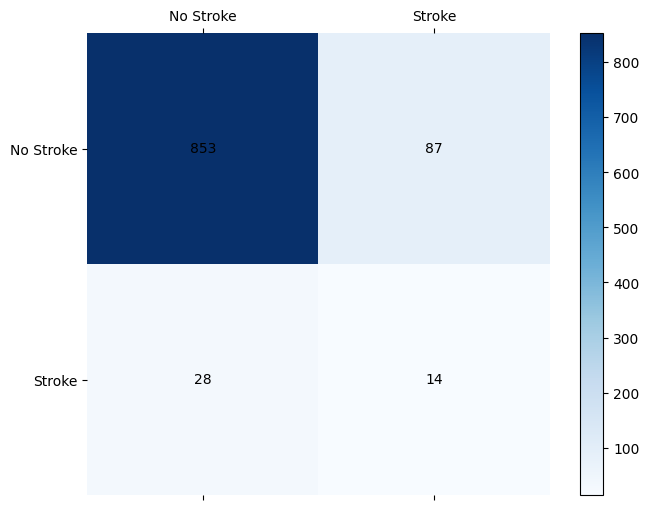

In [59]:
perform_model("Logistic", x_res, y_res, x_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       940
           1       0.09      0.10      0.09        42

    accuracy                           0.92       982
   macro avg       0.52      0.53      0.52       982
weighted avg       0.92      0.92      0.92       982

Balanced Accuracy: 0.5258105369807498
F1 Weighted: 0.9208746805570464
F1 Macro: 0.5249327919950519
[[899  41]
 [ 38   4]]


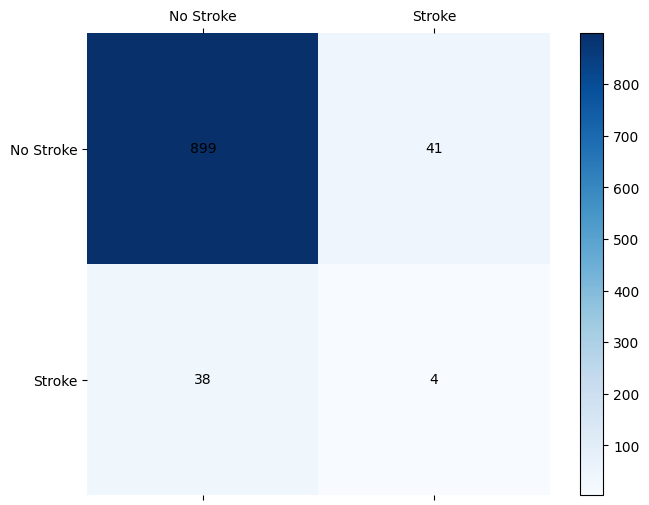

In [43]:
perform_model("RF", x_res, y_res, x_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       940
           1       0.07      0.14      0.09        42

    accuracy                           0.88       982
   macro avg       0.51      0.53      0.51       982
weighted avg       0.92      0.88      0.90       982

Balanced Accuracy: 0.5283434650455927
F1 Weighted: 0.900175531404841
F1 Macro: 0.5146315189151511
[[859  81]
 [ 36   6]]


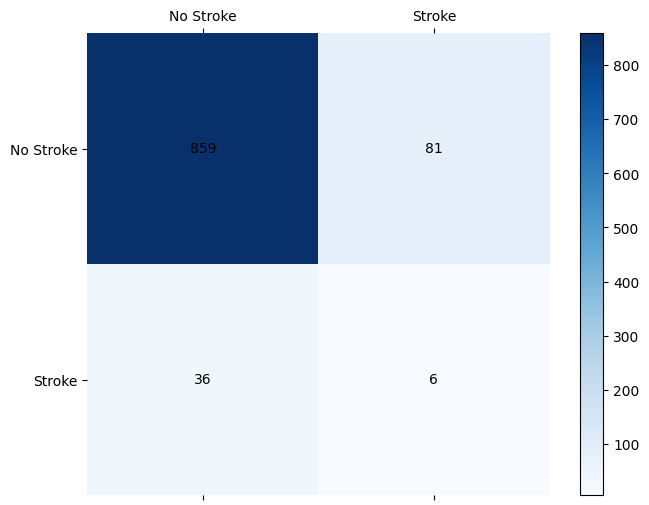

In [ ]:
perform_model("SVM", x_res, y_res, x_test, y_test)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       940
           1       0.05      0.05      0.05        42

    accuracy                           0.92       982
   macro avg       0.51      0.50      0.50       982
weighted avg       0.92      0.92      0.92       982

Balanced Accuracy: 0.504660587639311
F1 Weighted: 0.920754256013768
F1 Macro: 0.5048301486199576
[[904  36]
 [ 40   2]]


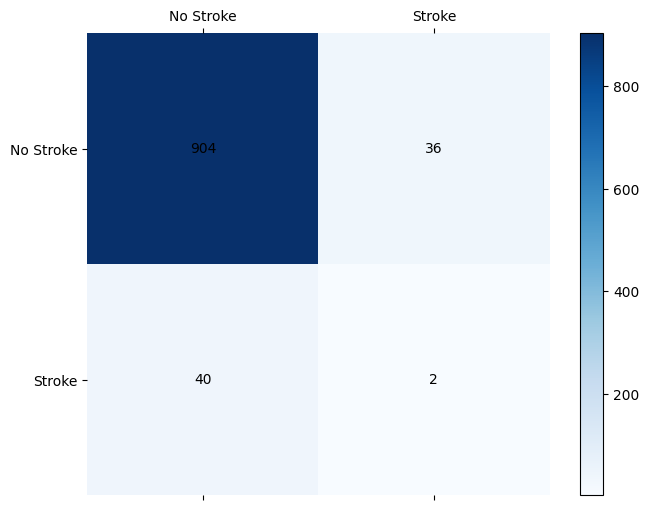

In [ ]:
perform_model("XGB", x_res, y_res, x_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       940
           1       0.12      0.55      0.20        42

    accuracy                           0.82       982
   macro avg       0.55      0.69      0.55       982
weighted avg       0.94      0.82      0.87       982

Balanced Accuracy: 0.6876393110435663
F1 Weighted: 0.8661512462998024
F1 Macro: 0.5492202617810342
[[778 162]
 [ 19  23]]


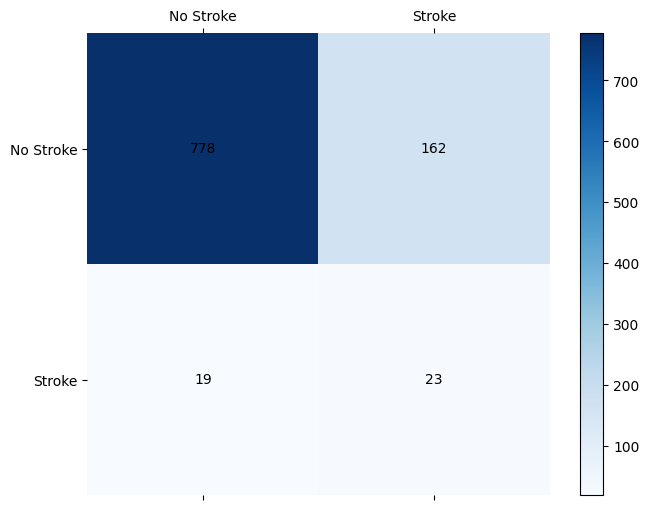

In [ ]:
perform_model("KNN", x_res, y_res, x_test, y_test)